In [1]:
import h5py
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import glob
import ray

ray.init(num_cpus=40)

/srvfs/home/uvoggenberger/micromamba/envs/uv12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-06-03 12:34:23,992	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-06-03 12:34:26,792	INFO worker.py:1841 -- Started a local Ray instance.


Python version:,3.12.3
Ray version:,2.43.0


In [2]:
def z_to_p_ifs(h): # geopotential height (m^/s^2) to pressure (Pa)
    a = 5.252368255329
    b = 44330.769230769
    c = 0.000157583169442
    ptro = 226.547172
    po = 1013.25
    g = 9.80665
 
    h /= g
    if h != h:

        p = h

    elif h > 11000.0:

        y = -c * (h - 11000.0)

        p = ptro * np.exp(y)

    else:

        y = 1.0 - h / b

        p = po * (y**a)

    return p * 100. # we want Pa

# Worlmap Plot

In [4]:
@ray.remote
def process_station_file(file):
    statid = file.split('/')[-1].split('.')[0]
    with h5py.File(file, 'r') as fl:
        x = fl['observations_table']['observed_variable'][:]
        val = fl['observations_table']['observation_value'][:]
        p = fl['observations_table']['z_coordinate'][:]
        rid_raw = fl['observations_table']['report_id'][:]
        lat_z = fl['observations_table']['latitude'][-1]
        lon_z = fl['observations_table']['longitude'][-1]

    # Convert report_id to strings
    report_ids = ["".join(byte.decode() for byte in rid).strip() for rid in rid_raw]

    # Group by report_id
    from collections import defaultdict
    report_obs = defaultdict(list)

    for var, v, pr, rid in zip(x, val, p, report_ids): #, lat, lon):
        report_obs[rid].append((var, v, pr)) #   la, lo))

    results_temp = []
    results_pilot = []

    for rid, obs in report_obs.items():
        observed_vars = [o[0] for o in obs]
        has_126 = 126 in observed_vars

        # Filter pressure
        obs_200_400 = [o for o in obs if 27000 <= o[2] <= 32000]
        if not obs_200_400:
            continue

        u_vals = [o[1] for o in obs_200_400 if o[0] == 139]
        v_vals = [o[1] for o in obs_200_400 if o[0] == 140]

        if not u_vals or not v_vals:
            continue

        u_mean = np.mean(u_vals)
        v_mean = np.mean(v_vals)
        lat_m = lat_z # obs_200_400[0][3] 
        lon_m = lon_z # obs_200_400[0][4] 
        result = (lat_m, lon_m, u_mean, v_mean)

        if has_126:
            results_temp.append(result)
        else:
            results_pilot.append(result)

    lat = []
    lon = []
    u = []
    v = []
    if len(results_pilot) <= 10:
        lat.append(np.nan) 
        lon.append(np.nan) 
        u.append(np.nan) 
        v.append(np.nan) 
    else:
        for entry in results_pilot:
            lat.append(entry[0]) 
            lon.append(entry[1]) 
            u.append(entry[2]) 
            v.append(entry[3]) 
    results_pilot = [np.mean(lat), np.mean(lon), np.mean(u), np.mean(v), statid]

    lat = []
    lon = []
    u = []
    v = []
    if len(results_temp) <= 10:
        lat.append(np.nan) 
        lon.append(np.nan) 
        u.append(np.nan) 
        v.append(np.nan) 
    else:
        for entry in results_temp:
            lat.append(entry[0]) 
            lon.append(entry[1]) 
            u.append(entry[2]) 
            v.append(entry[3]) 
    results_temp = [np.mean(lat), np.mean(lon), np.mean(u), np.mean(v), statid]    

    return [results_temp, results_pilot]


In [5]:
@ray.remote
def process_station_file_pseudo_pilot(file):

    statid = file.split('/')[-1].split('.')[0]
    with h5py.File(file, 'r') as fl:
        x = fl['observations_table']['observed_variable'][:]
        val = fl['observations_table']['observation_value'][:]
        p = fl['observations_table']['z_coordinate'][:]
        rid_raw = fl['observations_table']['report_id'][:]
        lat_z = fl['observations_table']['latitude'][-1]
        lon_z = fl['observations_table']['longitude'][-1]

    # Convert report_id to strings
    report_ids = ["".join(byte.decode() for byte in rid).strip() for rid in rid_raw]

    # Group by report_id
    from collections import defaultdict
    report_obs = defaultdict(list)

    for var, v, pr, rid in zip(x, val, p, report_ids): #, lat, lon):
        report_obs[rid].append((var, v, pr)) #, la, lo))

    results_temp = []
    results_pilot = []
    results_pseudo_pilot = []

    for rid, obs in report_obs.items():
        observed_vars = [o[0] for o in obs]
        if not 126 in observed_vars:
            continue
        
        # Open a wider window for pressure conversion:
        obs_100_500 = [o for o in obs if 10000 <= o[2] <= 50000]

        u_vals = [o[1] for o in obs_100_500 if o[0] == 139]
        v_vals = [o[1] for o in obs_100_500 if o[0] == 140]
        g_vals = [o[1] for o in obs_100_500 if o[0] == 117]

        # Ensure all data is of the same shape:
        if len(g_vals) != len(u_vals) or len(g_vals) == 0:
            continue
        
        # Convert geopotential height to pressure using IFS formula
        p_vals = [z_to_p_ifs(i_g) for i_g in g_vals]

        # Recreate obs with only u_vals, v_vals, lat, lon, and use p_vals as pressure
        obs_uv = []
        i_g_v = 0
        i_g_u = 0
        for idx, (var, v, pr) in enumerate(obs_100_500): # , la, lo
            if var in [139]:
                obs_uv.append((var, v, p_vals[i_g_u])) # , la, lo
                i_g_u += 1
            if var in [140]:
                obs_uv.append((var, v, p_vals[i_g_v])) # , la, lo
                i_g_v += 1
                
        # Filter pressure as usual:
        obs_200_400 = [o for o in obs_uv if 27000 <= o[2] <= 32000]
        if not obs_200_400:
            continue

        u_vals = [o[1] for o in obs_200_400 if o[0] == 139]
        v_vals = [o[1] for o in obs_200_400 if o[0] == 140]

        if not u_vals or not v_vals:
            continue

        u_mean = np.mean(u_vals)
        v_mean = np.mean(v_vals)
        lat_m = lat_z # obs_200_400[0][3] 
        lon_m = lon_z #obs_200_400[0][4] 
        result = (lat_m, lon_m, u_mean, v_mean)

        results_temp.append(result)

    lat = []
    lon = []
    u = []
    v = []
    if len(results_temp) <= 10:
        lat.append(np.nan) 
        lon.append(np.nan) 
        u.append(np.nan) 
        v.append(np.nan) 
    else:
        for entry in results_temp:
            lat.append(entry[0]) 
            lon.append(entry[1]) 
            u.append(entry[2]) 
            v.append(entry[3]) 
    results_temp = [np.mean(lat), np.mean(lon), np.mean(u), np.mean(v), statid]    

    return [results_temp]

In [6]:
def plot_station_winds_uv(results, wind='u', vma = -50, vmi = 50, title="Wind Components (400–200 hPa)"):

    lats = [r[0] for r in results] # if not np.isnan(r[0])]
    lons = [r[1] for r in results] # if not np.isnan(r[1])]
    us = [r[2] for r in results] # if not np.isnan(r[2])]
    vs = [r[3] for r in results] # if not np.isnan(r[3])]

    if len(lats) == 0 or len(lons) == 0 or len(us) == 0 or len(vs) == 0:
        print("No valid data to plot.")
        return

    plt.figure(figsize=(16, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_global()
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN, facecolor='lightblue')
    ax.gridlines(draw_labels=True)

    # Plot colored scatter plots for u and v components
    if wind == 'u':
        sc_u = ax.scatter(lons, lats, c=us, cmap='coolwarm', s=80, marker='o', edgecolor='k', vmin=vmi, vmax=vma, transform=ccrs.PlateCarree())
        cbar = plt.colorbar(sc_u, ax=ax, orientation='vertical', label='U component (m/s)', shrink=0.7, pad=0.02)
        plt.title(title + " - U component")
        plt.tight_layout()
        plt.show()
        plt.savefig(f"{title.replace(' ', '_').lower()}_u.png", dpi=300)
        plt.close()
    if wind == 'v':
        sc_v = ax.scatter(lons, lats, c=vs, cmap='coolwarm', s=80, marker='o', edgecolor='k', vmin=vmi, vmax=vma, transform=ccrs.PlateCarree())
        cbar = plt.colorbar(sc_v, ax=ax, orientation='vertical', label='V component (m/s)', shrink=0.7, pad=0.02)
        plt.title(title + " - V component")
        plt.tight_layout()
        plt.show()
        plt.savefig(f"{title.replace(' ', '_').lower()}_v.png", dpi=300)
        plt.close()




In [7]:
files = glob.glob("/mnt/users/scratch/leo/scratch/converted_v29/1985/*.nc", recursive=True)[:]
# results = process_station_file(files[0])
futures = [process_station_file.remote(f) for f in files]
results = ray.get(futures)


In [8]:
files = glob.glob("/mnt/users/scratch/leo/scratch/converted_v29/1985/*.nc", recursive=True)[:]
futures = [process_station_file_pseudo_pilot.remote(f) for f in files]
results_pseudo = ray.get(futures)


In [9]:
rn = np.array(results, dtype=object)[:,0,:]
rp = np.array(results, dtype=object)[:,1,:]
rpp = np.array(results_pseudo, dtype=object)[:,0,:]

In [10]:
def result_difference(rn, rp):
    mask1 = ~np.isnan(np.array(rn[:,0], dtype=float)) & ~np.isnan(np.array(rn[:,1], dtype=float))
    mask2 = ~np.isnan(np.array(rp[:,0], dtype=float)) & ~np.isnan(np.array(rp[:,1], dtype=float))

    valid1 = rn[mask1]
    valid2 = rp[mask2]


    # Create dictionaries mapping station names to rows
    dict1 = {row[4]: row for row in valid1}
    dict2 = {row[4]: row for row in valid2}

    # Find common station names
    common_stations = set(dict1.keys()) & set(dict2.keys())

    # Prepare result list
    result = []

    for station in common_stations:
        row1 = dict1[station]
        row2 = dict2[station]
        
        diff_col2 = row1[2] - row2[2]
        diff_col3 = row1[3] - row2[3]
        
        result.append([row1[0], row1[1], diff_col2, diff_col3, station])

    # Convert to structured array
    result_differences = np.array(result, dtype=object)
    return result_differences



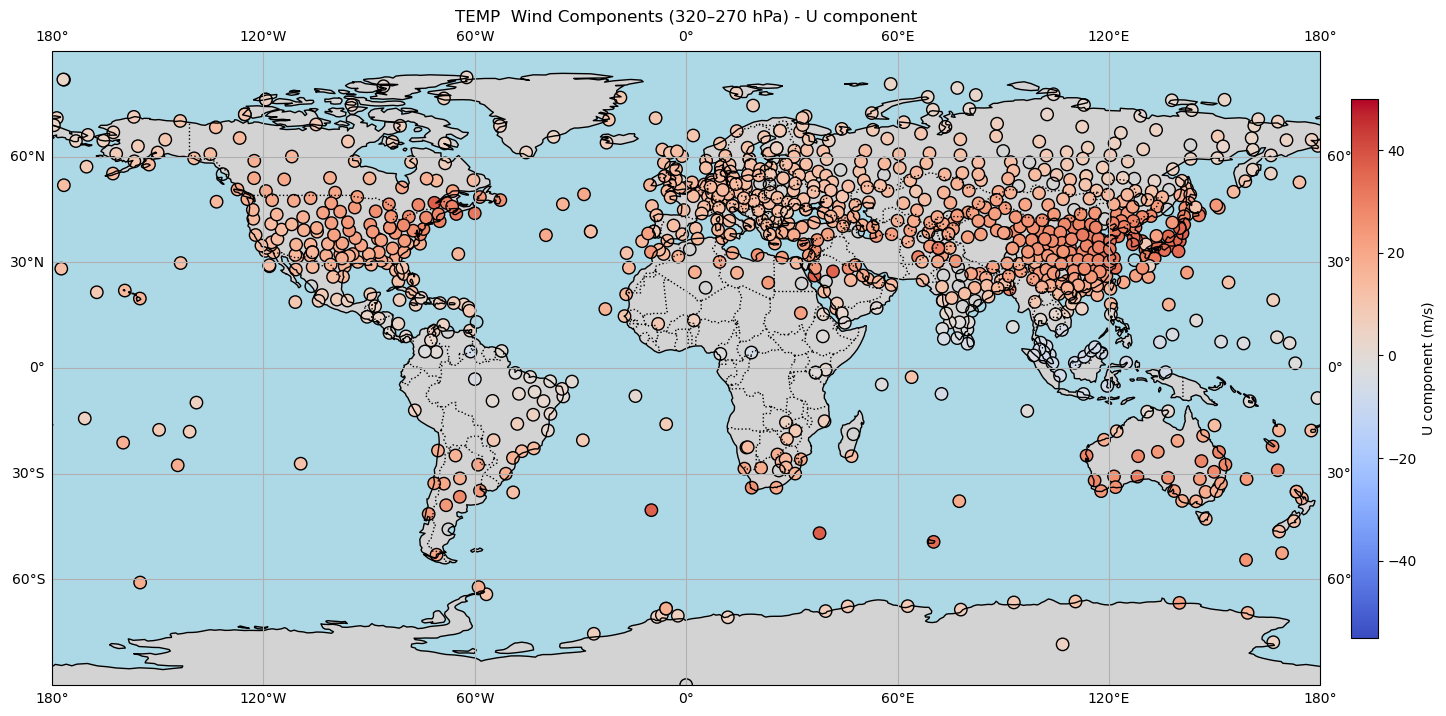

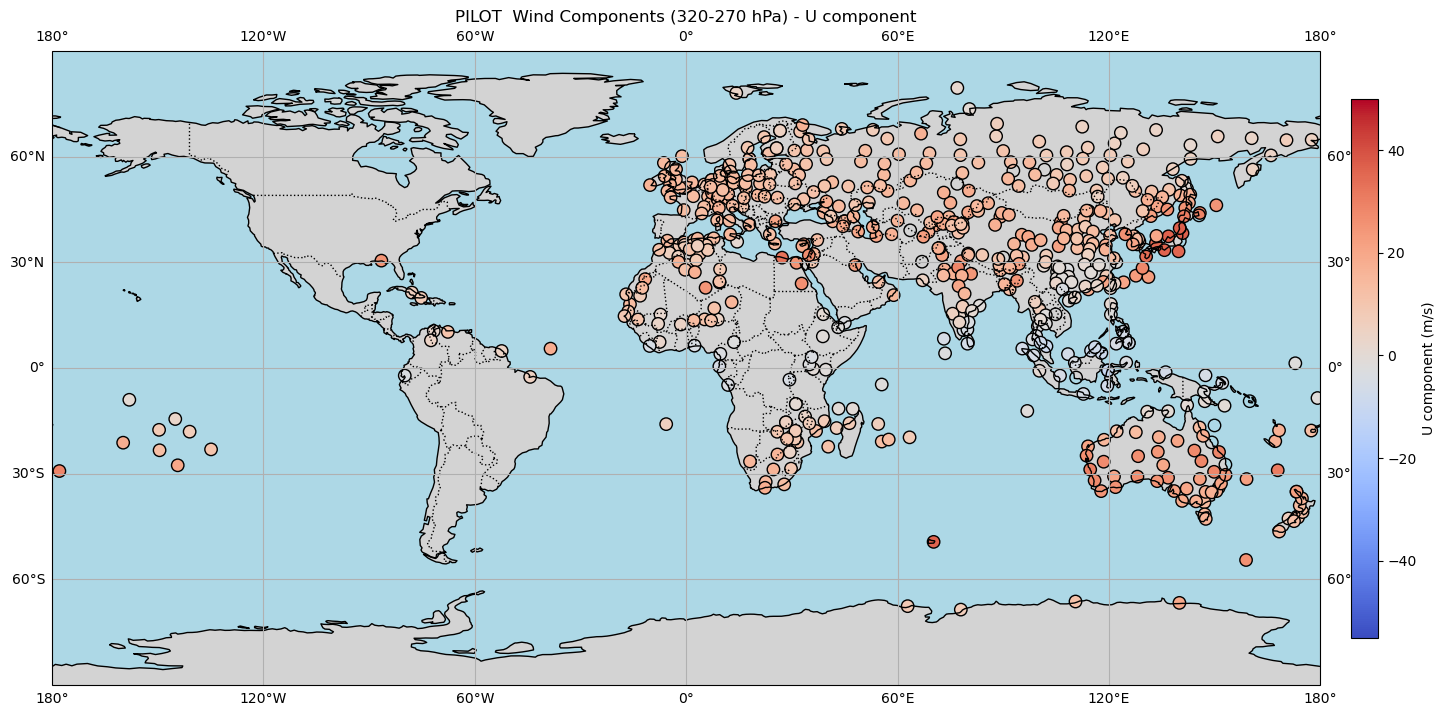

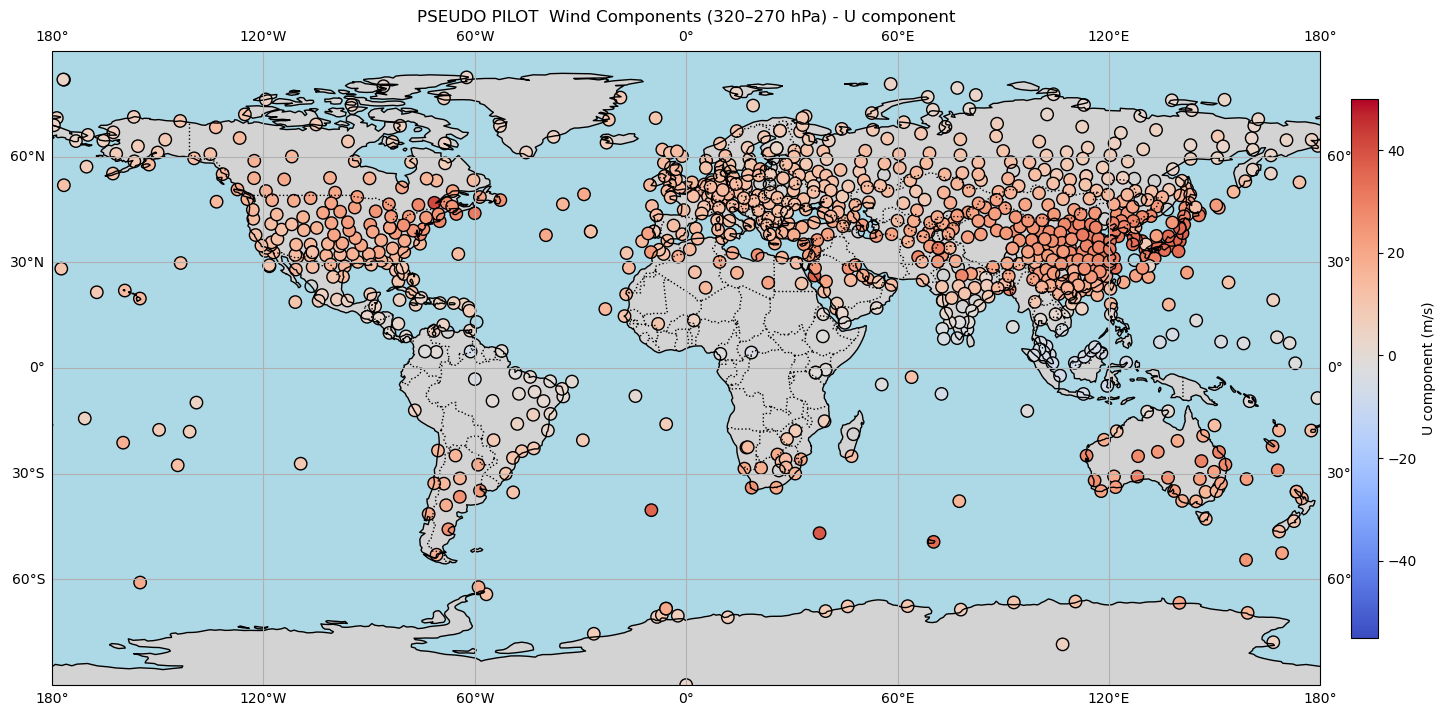

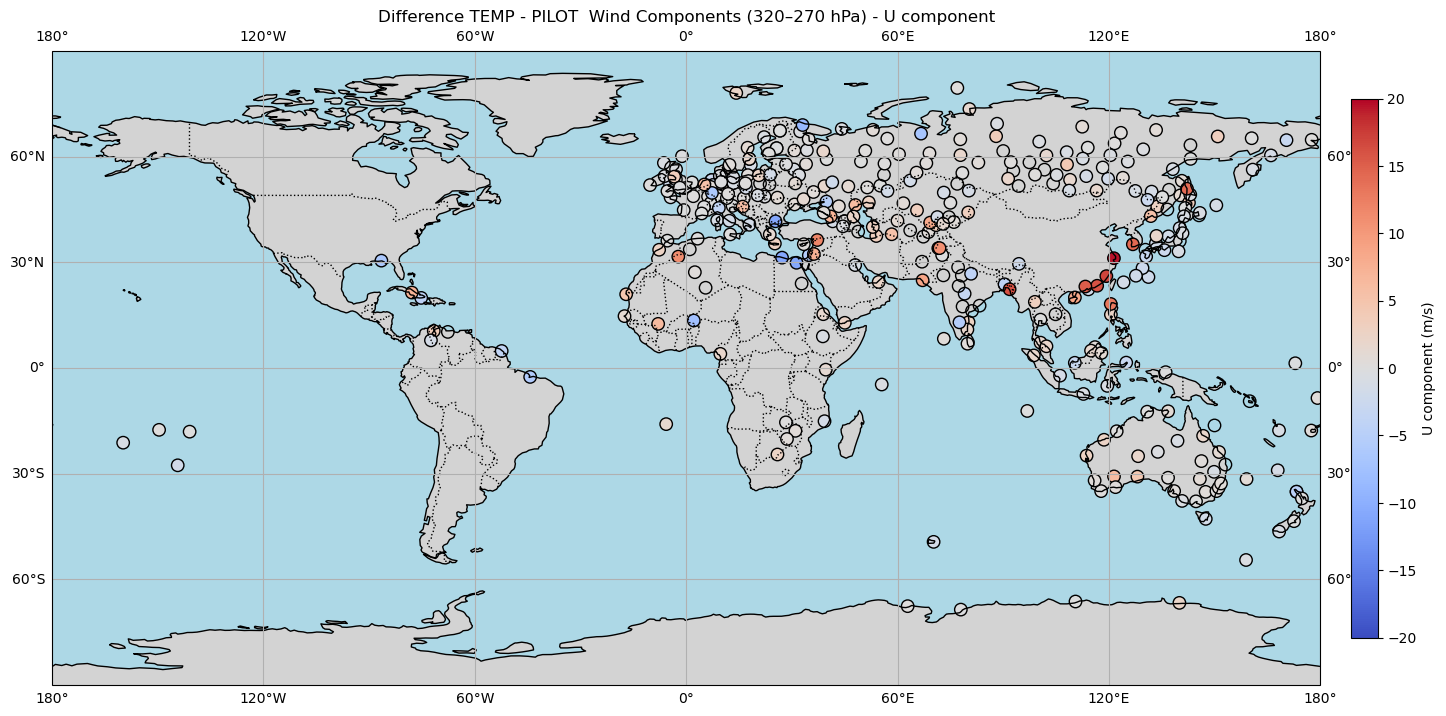

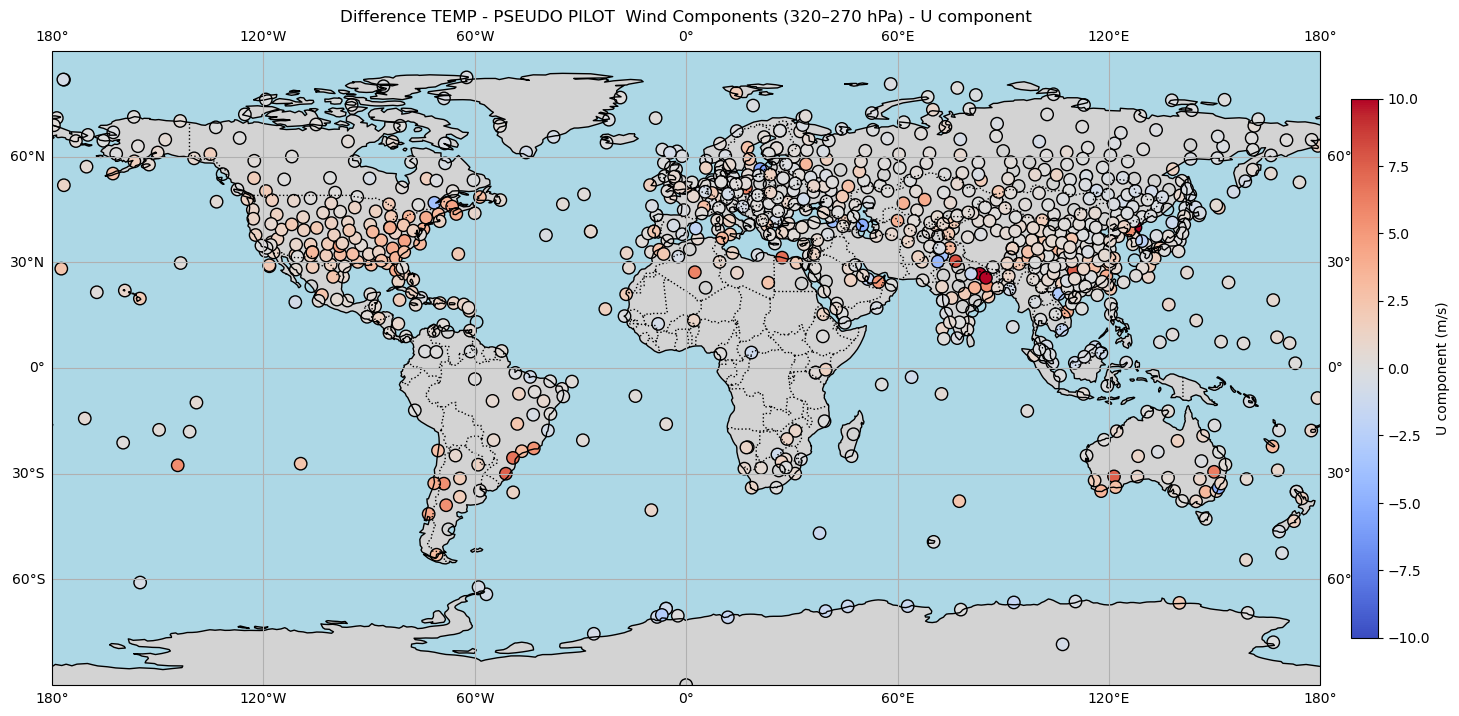

In [11]:
plot_station_winds_uv(rn, wind='u', title="TEMP  Wind Components (320–270 hPa)")
plot_station_winds_uv(rp, wind='u', title="PILOT  Wind Components (320-270 hPa)")
plot_station_winds_uv(rpp, wind='u', title="PSEUDO PILOT  Wind Components (320–270 hPa)")
plot_station_winds_uv(result_difference(rn, rp), wind='u', title="Difference TEMP - PILOT  Wind Components (320–270 hPa)", vmi = -20, vma = 20)
plot_station_winds_uv(result_difference(rn, rpp), wind='u', title="Difference TEMP - PSEUDO PILOT  Wind Components (320–270 hPa)", vmi = -10, vma = 10)


# Histogram

In [12]:
def plot_dist_histogram(result, title=""):
    # Bin edges for latitude (5° bins)
    lat_bins = np.arange(-90, 95, 5)  # from -90 to 90 in 5° steps

    # Digitize latitudes to bin indices
    bin_indices = np.digitize(result[:, 0], lat_bins)

    # Mean differences in third and fourth columns for each latitude bin
    mean_diffs_col2 = []
    mean_diffs_col3 = []
    bin_centers = []

    for i in range(1, len(lat_bins)):
        in_bin = result[bin_indices == i]
        if len(in_bin) > 0:
            mean_diff2 = np.nanmean(in_bin[:, 2])
            mean_diff3 = np.nanmean(in_bin[:, 3])
            mean_diffs_col2.append(mean_diff2)
            mean_diffs_col3.append(mean_diff3)
            bin_center = (lat_bins[i-1] + lat_bins[i]) / 2
            bin_centers.append(bin_center)

    mean_diffs_col2 = np.array(mean_diffs_col2)
    mean_diffs_col3 = np.array(mean_diffs_col3)
    bin_centers = np.array(bin_centers)

    # Plot histograms of mean differences
    plt.figure(figsize=(10, 6))
    plt.bar(bin_centers - 1.25, mean_diffs_col2, width=2.5, label='Mean Difference U', alpha=0.7)
    plt.bar(bin_centers + 1.25, mean_diffs_col3, width=2.5, label='Mean Difference V', alpha=0.7)
    plt.xlabel('Latitude (°)')
    plt.ylabel('Mean Difference')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


/tmp/ipykernel_2248526/3597035248.py:16: RuntimeWarning: Mean of empty slice
  mean_diff2 = np.nanmean(in_bin[:, 2])


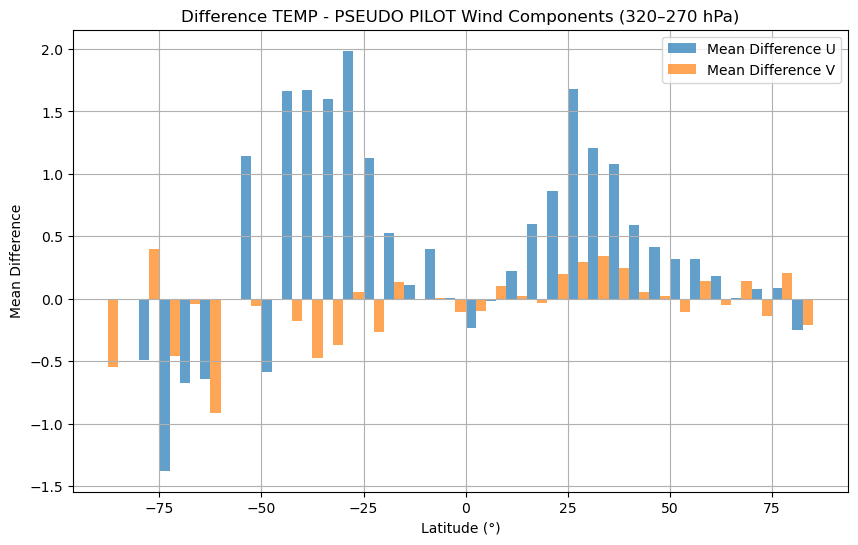

In [13]:
plot_dist_histogram(result_difference(rn, rpp), "Difference TEMP - PSEUDO PILOT Wind Components (320–270 hPa)")


# Countour Plot

In [3]:
@ray.remote
def process_station_file_combined(
    file,
    types=["temp", "pilot", "pseudo_pilot"],
    pressure_level=30000,
    pressure_tolerance=2000,
    preselect_tolerance=10000
):
    statid = file.split('/')[-1].split('.')[0]
    with h5py.File(file, 'r') as fl:
        x = fl['observations_table']['observed_variable'][:]
        val = fl['observations_table']['observation_value'][:]
        p = fl['observations_table']['z_coordinate'][:]
        rid_raw = fl['observations_table']['report_id'][:]
        lat_z = fl['observations_table']['latitude'][-1]
        lon_z = fl['observations_table']['longitude'][-1]

    report_ids = ["".join(byte.decode() for byte in rid).strip() for rid in rid_raw]

    from collections import defaultdict
    report_obs = defaultdict(list)
    for var, v, pr, rid in zip(x, val, p, report_ids):
        report_obs[rid].append((var, v, pr))

    results_temp = []
    results_pilot = []
    results_pseudo_pilot = []

    # Define pressure windows
    target_min = pressure_level - pressure_tolerance
    target_max = pressure_level + pressure_tolerance
    preselect_min = pressure_level - preselect_tolerance
    preselect_max = pressure_level + preselect_tolerance

    for rid, obs in report_obs.items():
        observed_vars = [o[0] for o in obs]

        has_126 = 126 in observed_vars
        has_117 = 117 in observed_vars

        # --- PSEUDO-PILOT ---
        if "pseudo_pilot" in types and has_126 and has_117:
            obs_preselect = [o for o in obs if preselect_min <= o[2] <= preselect_max]
            u_vals = [o[1] for o in obs_preselect if o[0] == 139]
            v_vals = [o[1] for o in obs_preselect if o[0] == 140]
            g_vals = [o[1] for o in obs_preselect if o[0] == 117]

            if len(g_vals) != len(u_vals) or len(g_vals) == 0:
                continue

            p_vals = [z_to_p_ifs(i_g) for i_g in g_vals]

            obs_uv = []
            i_g_u = 0
            i_g_v = 0
            for var, v, _ in obs_preselect:
                if var == 139 and i_g_u < len(p_vals):
                    obs_uv.append((var, v, p_vals[i_g_u]))
                    i_g_u += 1
                elif var == 140 and i_g_v < len(p_vals):
                    obs_uv.append((var, v, p_vals[i_g_v]))
                    i_g_v += 1

            obs_target = [o for o in obs_uv if target_min <= o[2] <= target_max]
            if not obs_target:
                continue

            u_vals = [o[1] for o in obs_target if o[0] == 139]
            v_vals = [o[1] for o in obs_target if o[0] == 140]

            if not u_vals or not v_vals:
                continue

            results_pseudo_pilot.append((lat_z, lon_z, np.mean(u_vals), np.mean(v_vals)))

        # --- TEMP ---
        if "temp" in types and has_126:
            obs_target = [o for o in obs if target_min <= o[2] <= target_max]
            u_vals = [o[1] for o in obs_target if o[0] == 139]
            v_vals = [o[1] for o in obs_target if o[0] == 140]

            if not u_vals or not v_vals:
                continue

            results_temp.append((lat_z, lon_z, np.mean(u_vals), np.mean(v_vals)))

        # --- PILOT ---
        if "pilot" in types and not has_126:
            obs_target = [o for o in obs if target_min <= o[2] <= target_max]
            u_vals = [o[1] for o in obs_target if o[0] == 139]
            v_vals = [o[1] for o in obs_target if o[0] == 140]

            if not u_vals or not v_vals:
                continue

            results_pilot.append((lat_z, lon_z, np.mean(u_vals), np.mean(v_vals)))

    def summarize(results):
        if len(results) <= 10:
            return [np.nan, np.nan, np.nan, np.nan, statid]
        lat, lon, u, v = zip(*results)
        return [np.mean(lat), np.mean(lon), np.mean(u), np.mean(v), statid]

    output = {}
    if "temp" in types:
        output["temp"] = summarize(results_temp)
    if "pilot" in types:
        output["pilot"] = summarize(results_pilot)
    if "pseudo_pilot" in types:
        output["pseudo_pilot"] = summarize(results_pseudo_pilot)

    return output

In [29]:
for YYYY in range(1990, 2000):
    station_files = glob.glob(f"/mnt/users/scratch/leo/scratch/converted_v29/{YYYY}/*.nc", recursive=True)[:]

    pressure_levels = np.arange(75000, 9999, -5000)
    pressure_tolerance = 2500
    preselect_tolerance = 10000

    results_temp_all = {}
    results_pseudo_all = {}

    # Path to saved data
    temp_path = f"saved_results_{YYYY}_2500/results_temp_all.pkl"
    pseudo_path = f"saved_results_{YYYY}_2500/results_pseudo_all.pkl"

    # Check if files exist
    if os.path.exists(temp_path) and os.path.exists(pseudo_path):
        print("Loading saved results...")
        with open(temp_path, "rb") as f:
            results_temp_all = pickle.load(f)
        with open(pseudo_path, "rb") as f:
            results_pseudo_all = pickle.load(f)
    else:
        # Loop through pressure levels and store results
        for plevel in pressure_levels:
            print(f"Processing pressure level: {plevel} Pa")
            temp_futures = [process_station_file_combined.remote(f, types=["temp"],
                                pressure_level=plevel, pressure_tolerance=pressure_tolerance,
                                preselect_tolerance=preselect_tolerance) for f in station_files]

            pseudo_futures = [process_station_file_combined.remote(f, types=["pseudo_pilot"],
                                pressure_level=plevel, pressure_tolerance=pressure_tolerance,
                                preselect_tolerance=preselect_tolerance) for f in station_files]

            temp_results = ray.get(temp_futures)
            pseudo_results = ray.get(pseudo_futures)

            temp_array = np.array([res.get("temp", [np.nan]*5) for res in temp_results], dtype=object)
            pseudo_array = np.array([res.get("pseudo_pilot", [np.nan]*5) for res in pseudo_results], dtype=object)

            results_temp_all[plevel] = temp_array
            results_pseudo_all[plevel] = pseudo_array

        # Save to disk
        os.makedirs(temp_path.split('/')[0], exist_ok=True)
        with open(temp_path, "wb") as f:
            pickle.dump(results_temp_all, f)
        with open(pseudo_path, "wb") as f:
            pickle.dump(results_pseudo_all, f)
        print("Computation complete and results saved.")



Processing pressure level: 75000 Pa
Processing pressure level: 70000 Pa
Processing pressure level: 65000 Pa
Processing pressure level: 60000 Pa
Processing pressure level: 55000 Pa
Processing pressure level: 50000 Pa
Processing pressure level: 45000 Pa
Processing pressure level: 40000 Pa
Processing pressure level: 35000 Pa
Processing pressure level: 30000 Pa
Processing pressure level: 25000 Pa
Processing pressure level: 20000 Pa
Processing pressure level: 15000 Pa
Processing pressure level: 10000 Pa
Computation complete and results saved.
Processing pressure level: 75000 Pa
Processing pressure level: 70000 Pa
Processing pressure level: 65000 Pa
Processing pressure level: 60000 Pa
Processing pressure level: 55000 Pa
Processing pressure level: 50000 Pa
Processing pressure level: 45000 Pa
Processing pressure level: 40000 Pa
Processing pressure level: 35000 Pa
Processing pressure level: 30000 Pa
Processing pressure level: 25000 Pa
Processing pressure level: 20000 Pa
Processing pressure leve

In [5]:
def result_difference(rn, rp):
    mask1 = ~np.isnan(np.array(rn[:,0], dtype=float)) & ~np.isnan(np.array(rn[:,1], dtype=float))
    mask2 = ~np.isnan(np.array(rp[:,0], dtype=float)) & ~np.isnan(np.array(rp[:,1], dtype=float))
    valid1 = rn[mask1]
    valid2 = rp[mask2]
    dict1 = {row[4]: row for row in valid1}
    dict2 = {row[4]: row for row in valid2}
    common_stations = set(dict1.keys()) & set(dict2.keys())
    result = []
    for station in common_stations:
        row1 = dict1[station]
        row2 = dict2[station]
        diff_col2 = row1[2] - row2[2]
        diff_col3 = row1[3] - row2[3]
        result.append([row1[0], row1[1], diff_col2, diff_col3, station])
    return np.array(result, dtype=object)

diff_by_pressure = {}

for plevel in pressure_levels:
    diff_by_pressure[plevel] = result_difference(results_temp_all[plevel], results_pseudo_all[plevel])


In [27]:
def aggregate_by_latitude(result):
    result = np.array(result)
    lat_bins = np.arange(-90, 95, 5)
    bin_indices = np.digitize(result[:, 0], lat_bins)

    bin_indices = np.digitize(result[:, 0], lat_bins)
    mean_diffs = []
    for i in range(1, len(lat_bins)):
        in_bin = result[bin_indices == i]
        if len(in_bin) > 0:
            mean_u = np.nanmean(in_bin[:, 2])
            mean_v = np.nanmean(in_bin[:, 3])
        else:
            mean_u = np.nan
            mean_v = np.nan
        mean_diffs.append((mean_u, mean_v))
    return np.array(mean_diffs), (lat_bins[:-1] + lat_bins[1:]) / 2  # bin centers


In [7]:
all_u_diffs = []
all_v_diffs = []

for plevel in pressure_levels:
    diff = diff_by_pressure[plevel]
    mean_diffs, lat_centers = aggregate_by_latitude(diff)
    all_u_diffs.append(mean_diffs[:, 0])
    all_v_diffs.append(mean_diffs[:, 1])

all_u_diffs = np.array(all_u_diffs)  # shape: (n_levels, n_lat_bins)
all_v_diffs = np.array(all_v_diffs)


/tmp/ipykernel_2448601/2420777366.py:9: RuntimeWarning: Mean of empty slice
  mean_v = np.nanmean(in_bin[:, 3])


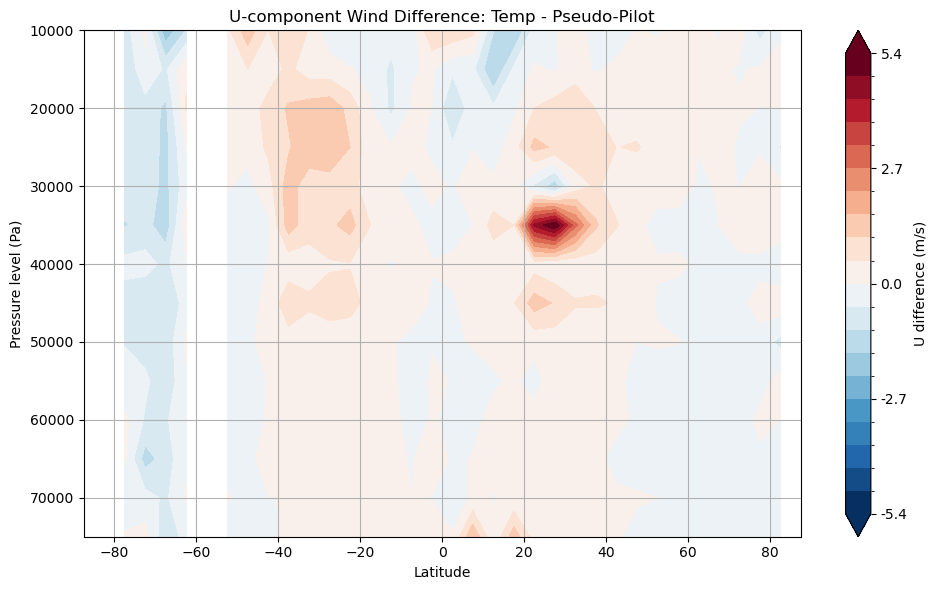

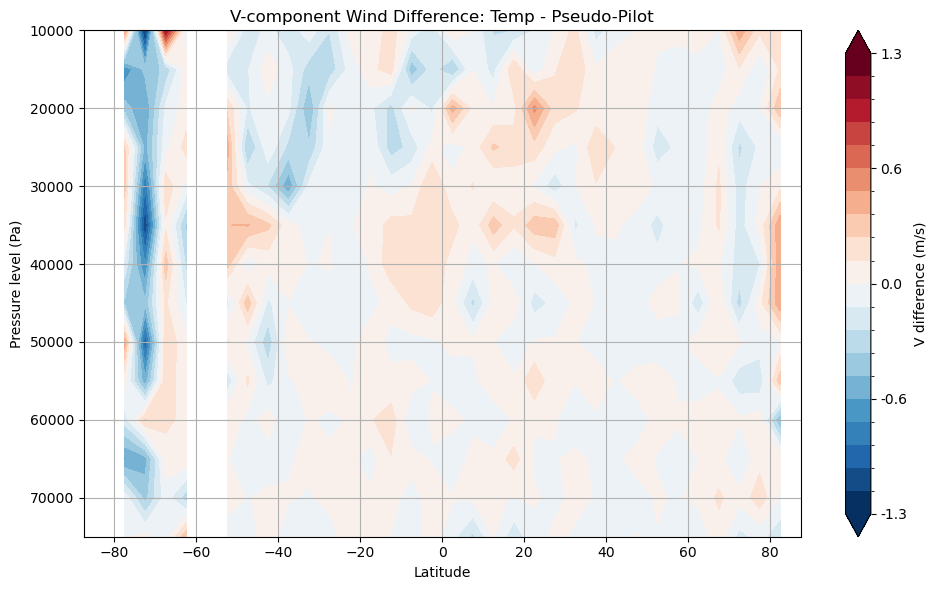

In [8]:
# from matplotlib.colors import TwoSlopeNorm
from matplotlib.colors import BoundaryNorm

def plot_diff_contour(data, lat_centers, pressure_levels, component="U"):
    # Remove NaNs to compute symmetric vlim
    finite_vals = data[np.isfinite(data)]
    if finite_vals.size == 0:
        vlim = 1
    else:
        vlim = np.nanmax(np.abs(finite_vals))
        
    # Overwrite vlim for better visualization:
    # vlim = 3

    # Create symmetric levels around 0, make sure 0 is included
    num_levels = 21  # Choose an odd number so 0 is in the center
    levels = np.linspace(-vlim, vlim, num_levels)
    norm = BoundaryNorm(boundaries=levels, ncolors=256)

    # Plot
    plt.figure(figsize=(10, 6))
    cp = plt.contourf(lat_centers, pressure_levels, data, levels=levels, cmap="RdBu_r", norm=norm, extend='both')

    # Add colorbar with centered 0
    cbar = plt.colorbar(cp, ticks=np.linspace(-vlim, vlim, 5))
    cbar.ax.set_yticklabels([f"{v:.1f}" for v in np.linspace(-vlim, vlim, 5)])
    cbar.set_label(f"{component} difference (m/s)")

    # Invert pressure axis and label
    plt.gca().invert_yaxis()
    plt.xlabel("Latitude")
    plt.ylabel("Pressure level (Pa)")
    plt.title(f"{component}-component Wind Difference: Temp - Pseudo-Pilot")
    plt.grid(True)
    plt.tight_layout()
    plt.show()



plot_diff_contour(all_u_diffs, lat_centers, pressure_levels, component="U")
plot_diff_contour(all_v_diffs, lat_centers, pressure_levels, component="V")


# 5 year plot:

In [30]:
# Collect all differences
combined_diffs_by_pressure = {}
pressure_levels = np.arange(75000, 9999, -5000)
for pi in pressure_levels:
    combined_diffs_by_pressure[pi] = []

for yr in range(1985, 1990):
    diffs_by_pressure = defaultdict(list)
    for pf in glob.glob(f"saved_results_{yr}_2500/*.pkl"):
        with open(pf, "rb") as f:
            data = pickle.load(f)
        if 'temp' in pf:
            results_temp_all = data
        if 'pseudo' in pf:
            results_pseudo_all = data

    for plevel in pressure_levels:
        combined_diffs_by_pressure[plevel].extend(result_difference(results_temp_all[plevel], results_pseudo_all[plevel]))

all_u_diffs = []
all_v_diffs = []

In [ ]:
# arr = np.array(combined_diffs_by_pressure[75000])[:,4]
# mask = np.array(["-0-54" not in s for s in arr])
# len(np.array(combined_diffs_by_pressure[75000])[mask])


4466

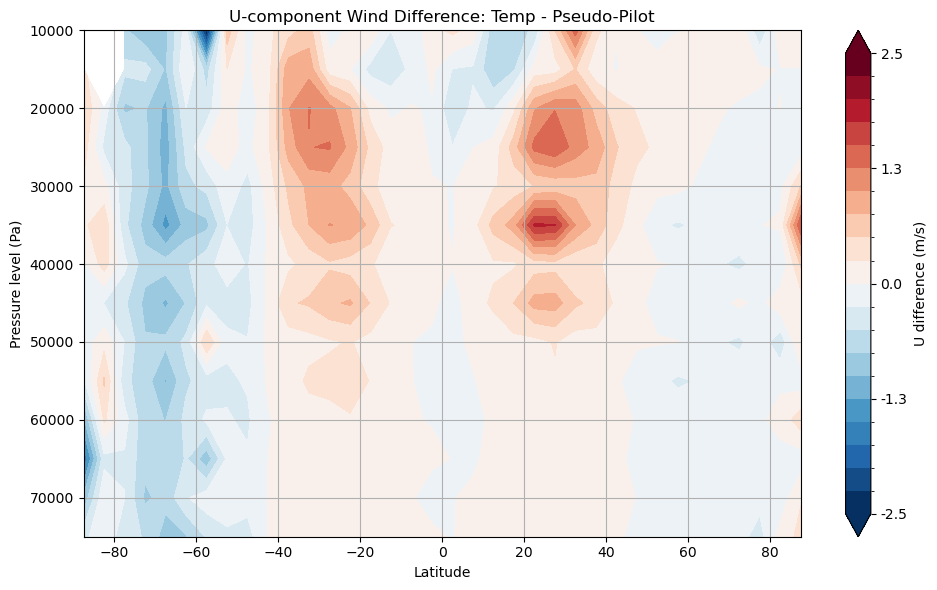

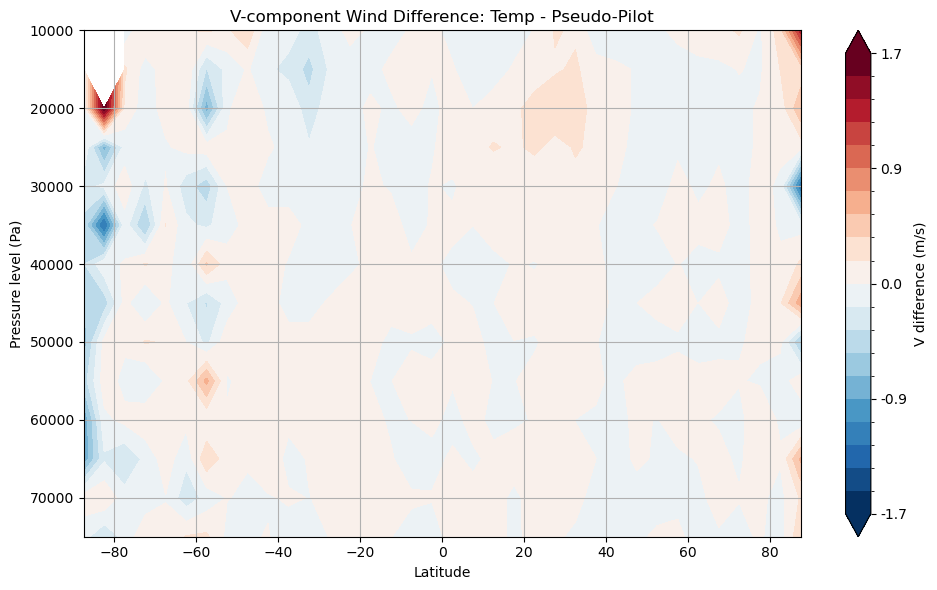

In [55]:
# Collect all differences
combined_diffs_by_pressure = {}
pressure_levels = np.arange(75000, 9999, -5000)
for pi in pressure_levels:
    combined_diffs_by_pressure[pi] = []

for yr in range(1985, 2000):
    diffs_by_pressure = defaultdict(list)
    for pf in glob.glob(f"saved_results_{yr}_2500/*.pkl"):
        with open(pf, "rb") as f:
            data = pickle.load(f)
        if 'temp' in pf:
            results_temp_all = data
        if 'pseudo' in pf:
            results_pseudo_all = data

    for plevel in pressure_levels:
        arr = result_difference(results_temp_all[plevel], results_pseudo_all[plevel])
        mask = np.array(["-0-5" not in s for s in np.array(arr)[:,4]])
        combined_diffs_by_pressure[plevel].extend(arr[mask])
        # combined_diffs_by_pressure[plevel].extend(arr)

all_u_diffs = []
all_v_diffs = []

for plevel in pressure_levels:
    diff = combined_diffs_by_pressure[plevel]
    mean_diffs, lat_centers = aggregate_by_latitude(diff)
    all_u_diffs.append(mean_diffs[:, 0])
    all_v_diffs.append(mean_diffs[:, 1])

all_u_diffs = np.array(all_u_diffs)  # shape: (n_levels, n_lat_bins)
all_v_diffs = np.array(all_v_diffs)

plot_diff_contour(all_u_diffs, lat_centers, pressure_levels, component="U")
plot_diff_contour(all_v_diffs, lat_centers, pressure_levels, component="V")



In [24]:
len(diff)

4486